Same as experiment 74, except here we swap the uniform kernel for a Gaussian one.

$$
k_\epsilon(\|f(x) - y\|) = \frac{1}{(2\pi)^{m/2}\epsilon^m}\exp\left(-\frac{\|f(x) - y\|^2}{2\epsilon^2}\right)
$$
$$
\log k_\epsilon(\|f(x) - y\|) = -\frac{m}{2}\log(2\pi) - m\log(\epsilon) -\frac{\|f(x) - y\|^2}{2\epsilon^2}
$$

We also implement log-computation, i.e. we compute weights as

$$
\bar{w}_{n, k}^{(i)} = \exp\left(\log\eta_{\epsilon_n}(x_{n-1, k}^{(i)}) - \log\eta_{\epsilon_{n-1}}(x_{n-1}^{(i)})\right)
$$

In [3]:
import numpy as np
from numpy import zeros, eye, array, diag, exp, pi, log
from numpy.linalg import solve, norm
from numpy.random import choice
from scipy.stats import multivariate_normal as MVN
import math
import time

import matplotlib.pyplot as plt
from matplotlib import rc
from ipywidgets.widgets import IntSlider
from ipywidgets.widgets import interact

from Manifolds.GeneralizedEllipse import GeneralizedEllipse
from utils import prep_contour
from RWM import RWM
from tangential_hug_functions import HugTangential

In [10]:
μ  = zeros(2)
Σ  = diag(array([0.1, 1]))
level_set_value = -2.9513586307684885
ellipse = GeneralizedEllipse(μ, Σ, exp(level_set_value))
πellipse = MVN(μ, Σ)
f = πellipse.logpdf
grad_f = lambda ξ: -solve(Σ, ξ - μ)

def generate_ηϵ(ϵ):
    """Generates ηϵ with a uniform kernel."""
    def ηϵ(x):
        # here m = 1
        return exp(- (f(x) - level_set_value)**2 / (2*ϵ**2)) / (((2*pi)**(1/2)) * (ϵ**1))
    return ηϵ

def generate_logηϵ(ϵ):
    """As above, this is for the uniform kernel but this computes the log density."""
    def logηϵ(x):
        return -(1/2)*log(2*pi) - 1*log(ϵ) - (((f(x) - level_set_value)**2) / (2*ϵ**2))
    return logηϵ

In [11]:
def THUGIntegratorUnivariate(z0, B, δ, grad):
    """THUG Integrator for the 2D example (ie using gradients, not jacobians)."""
    trajectory = zeros((B + 1, len(z0)))
    x0, v0 = z0[:len(z0)//2], z0[len(z0)//2:]
    x, v = x0, v0
    trajectory[0, :] = z0
    # Integrate
    for b in range(B):
        x = x + δ*v/2
        g = grad(x)
        ghat = g / norm(g)
        v = v - 2*ghat*(ghat@v)
        x = x + δ*v/2
        trajectory[b+1, :] = np.hstack((x, v))
    return trajectory

def generate_THUGIntegratorUnivariate(B, δ):
    """Returns a THUG integrator for a given B and δ."""
    grad = lambda ξ: -solve(Σ, ξ - μ) #ellipse.Q(ξ).T.flatten()
    integrator = lambda z: THUGIntegratorUnivariate(z, B, δ, grad)
    return integrator

###############################
#### this is for \tilde{ψ}.
###############################
def THUGIntegratorUnivariateOnlyEnd(z0, B, δ, grad):
    """Similar to THUG integrator but one step does B bounces."""
    trajectory = zeros((2, len(z0)))
    x0, v0 = z0[:len(z0)//2], z0[len(z0)//2:]
    x, v = x0, v0
    trajectory[0, :] = z0
    # Integrate
    for _ in range(B):
        x = x + δ*v/2
        g = grad(x)
        ghat = g / norm(g)
        v = v - 2*ghat*(ghat@v)
        x = x + δ*v/2
    trajectory[1, :] = np.hstack((x, v))
    return trajectory

def generate_THUGIntegratorUnivariateOnlyEnd(B, δ):
    """Returns a THUG integratorOnlyEnd for a given B and δ."""
    grad = lambda ξ: -solve(Σ, ξ - μ) #ellipse.Q(ξ).T.flatten()
    integrator = lambda z: THUGIntegratorUnivariateOnlyEnd(z, B, δ, grad)
    return integrator


#### Metropolis-Hastings version for SMC version
def THUG_MH(z0, B, δ, logpi):
    """Similar to THUGIntegratoUnivariateOnlyEnd but this uses a MH step."""
    grad = lambda ξ: -solve(Σ, ξ - μ)
    x0, v0 = z0[:len(z0)//2], z0[len(z0)//2:]
    x, v = x0, v0
    logu = np.log(np.random.rand())
    for _ in range(B):
        x = x + δ*v/2
        g = grad(x)
        ghat = g / norm(g)
        v = v - 2*ghat*(ghat@v)
        x = x + δ*v/2
    if logu <= logpi(x) - logpi(x0):
        # accept new point
        return np.concatenate((x, v))
    else:
        # accept old point
        return z0

# Markov Snippets (v1)

In [38]:
class MarkovSnippetsTHUG:
    
    def __init__(self, N, B, δ, d, ϵs, onlyend=False):
        """Markov Snippets SMC samplers corresponding exactly to Algorithm 1 in Christophe's notes.
        It uses the THUG kernel as its mutation kernel. The sequence of distributions is fixed here 
        since we provide ϵs, i.e. a list of tolerances which automatically fully specify the posterior 
        distributions used at each round.
        
        Parameters
        ----------
        
        :param N: Number of particles
        :type N:  int
        
        :param B: Number of bounces for the THUG integrator. Equivalent to `L` Leapfrog steps in HMC.
        :type B: int
        
        :param δ: Step-size used at each bounce, for the THUG integrator.
        :type δ: float
        
        :param d: Dimensionality of the `x` component of each particle, and equally dimensionality of 
                  `v` component of each particle. Therefore each particle has dimension `2d`.
        
        :param ϵs: Tolerances that fully specify the sequence of target filamentary distributions.
        :type ϵs: iterable
        
        :param onlyend: If False, we just run MS-SMC with the THUG integrator as kernel. If True, the THUG 
                        integrator is pretty much the same, but it only outputs the initial and final point, 
                        as part of the trajectory. Inside the integrator, it still performs B bounces, but 
                        basically we are changing \psi to \tilde{\psi} which performs B steps at once, and we 
                        run it only once.
        :type onlyend: bool
        """
        # Input variables
        self.N  = N       
        self.B  = B
        self.δ  = δ
        self.d  = d
        self.ϵs = ϵs       
        
        # Variables derived from the above
        self.P  = len(ϵs) - 1                                       # Number of target distributions
        self.ϖ  = MVN(zeros(d), eye(d))                             # Distribution of the velocities
        self.ηs = [generate_ηϵ(ϵ) for ϵ in ϵs]                      # List of filamentary distributions 
        self.log_ηs = [generate_logηε(ϵ) for ϵ in ϵs]
#         self.μs = [lambda z: ηϵ(z[:self.d]) for ηϵ in self.ηs]
        if not onlyend:
            self.ψ = generate_THUGIntegratorUnivariate(B, δ)
        else:
            self.ψ = generate_THUGIntegratorUnivariateOnlyEnd(B, δ)
            self.B = 1
    
    def initialize_particles(self):
        """To initialize particles, we sample from a uniform on a large rectangle.
        A rectangle of size [-100, 100] should be plenty large."""
        # Initialize first position on the manifold
        x0 = ellipse.sample(advanced=True)
        # Generate log-density for self.η[0]
        logηϵ0 = generate_logηϵ(self.ϵs[0])
        # Sample using RWM
        burn_in = 100
        TO_BE_THINNED, _ = RWM(x0, self.δ, burn_in + 10*self.N, logηϵ0)
        # Thin the samples to obtain the particles
        initialized_particles = TO_BE_THINNED[burn_in:][::10]
        # Refresh velocities and form particles
        v0 = np.random.normal(loc=0.0, scale=1.0, size=(self.N, self.d))
        z0 = np.hstack((initialized_particles, v0))
        self.starting_particles = z0
        return z0
        
    def sample(self):
        """Starts the Markov Snippets sampler."""
        starting_time = time.time() 
        N = self.N
        B = self.B
        ## Storage
        #### Store z_n^{(i)}
        self.ZN  = np.zeros((self.P+1, N, 2*self.d))
        #### Store z_{n, k}^{(i)} so basically all the N(T+1) particles
        self.ZNK  = np.zeros((self.P, N*(B+1), 2*self.d))
        self.Wbar = np.zeros((self.P, N*(B+1)))
        self.ESS  = np.zeros((self.P))
        self.K_RESAMPLED = zeros((self.P, self.N))
        # Initialize particles
        z = self.initialize_particles()   # (N, 2d)
        self.ZN[0] = z
        # For each target distribution, run the following loop
        for n in range(1, self.P+1):
            # Compute trajectories
            Z = np.apply_along_axis(self.ψ, 1, z) # should have shape (N, B+1, 2d)
            self.ZNK[n-1] = Z.reshape(N*(B+1), 2*self.d)
            # Compute weights.
            #### Denominator: shared for each point in the same trajectory
            log_μnm1_z  = np.apply_along_axis(self.log_ηs[n-1], 1, Z[:, 0, :self.d])              # (N, )
            log_μnm1_z  = np.repeat(log_μnm1_z, self.B+1, axis=0).reshape(N, B+1) # (N, B+1)
            #### Numerator: different for each point on a trajectory.
            log_μn_ψk_z = np.apply_along_axis(self.log_ηs[n], 2, Z[:, :, :self.d])                         # (N, B+1)
            #### Put weights together
            W = exp(log_μn_ψk_z - log_μnm1_z) #np.exp(log_μn_ψk_z - log_μnm1_z)
            #### Normalize weights
            W = W / W.sum()
            # store weights (remember these are \bar{w})
            self.Wbar[n-1] = W.flatten()
            # compute ESS
            self.ESS[n-1] = 1 / np.sum(W**2)
            # Resample down to N particles
            resampling_indeces = choice(a=np.arange(N*(B+1)), size=N, p=W.flatten())
            unravelled_indeces = np.unravel_index(resampling_indeces, (N, B+1))
            self.K_RESAMPLED[n-1] = unravelled_indeces[1]
            indeces = np.dstack(unravelled_indeces).squeeze()
            z = np.vstack([Z[tuple(ix)] for ix in indeces])     # (N, 2d)
            
            # Rejuvenate velocities of N particles
            z[:, self.d:] = np.random.normal(loc=0.0, scale=1.0, size=(N, self.d))
            self.ZN[n] = z
        self.total_time = time.time() - starting_time
        return z

In [39]:
# At this point, doesn't really matter which ϵs we use.
ϵs = np.geomspace(start=10, stop=0.001, num=20)
B = 50
δ = 0.1
N  = 10000

In [40]:
# Instantitate the algorithm
MSTHUG = MarkovSnippetsTHUG(N=N, B=B, δ=δ, d=2, ϵs=ϵs)
# Sample
zP = MSTHUG.sample()

# Markov Snippets (v2)

In [46]:
# The aim now is to only output the end of the trajectory with ψ.
MSTHUG_ONLYEND = MarkovSnippetsTHUG(N=N, B=B, δ=δ, d=2, ϵs=ϵs, onlyend=True)

In [47]:
zP_onlyend = MSTHUG_ONLYEND.sample()

# SMC

In [27]:
class MarkovSnippetsTHUGMetropolised:
    
    def __init__(self, N, B, δ, d, ϵs):
        """Metropolised version: for each particle compute the endpoint of trajectory and its weight.
        If the weight is positive, we accept the final point, otherwise we accept the initial point. 
        
        Parameters
        ----------
        
        :param N: Number of particles
        :type N:  int
        
        :param B: Number of bounces for the THUG integrator. Equivalent to `L` Leapfrog steps in HMC.
        :type B: int
        
        :param δ: Step-size used at each bounce, for the THUG integrator.
        :type δ: float
        
        :param d: Dimensionality of the `x` component of each particle, and equally dimensionality of 
                  `v` component of each particle. Therefore each particle has dimension `2d`.
        
        :param ϵs: Tolerances that fully specify the sequence of target filamentary distributions.
        :type ϵs: iterable
        """
        # Input variables
        self.N  = N       
        self.δ  = δ
        self.d  = d
        self.ϵs = ϵs       
        
        # Variables derived from the above
        self.P  = len(ϵs) - 1                                       # Number of target distributions
        self.ϖ  = MVN(zeros(d), eye(d))                             # Distribution of the velocities
        self.ηs = [generate_ηϵ(ϵ) for ϵ in ϵs]                      # List of filamentary distributions 
        
        self.B = B
    
    def initialize_particles(self):
        """To initialize particles, we sample from a uniform on a large rectangle.
        A rectangle of size [-100, 100] should be plenty large."""
        # Initialize particles by sampling from η_ϵ0 for a large ϵ0 which can be given as an argument.
        # Sample a point from the prior
        x0 = ellipse.sample(advanced=True) #np.random.uniform(low=-5, high=5, size=(self.d))
        # Use RWM starting from x0
        logηϵ0 = generate_logηϵ(self.ϵs[0])
        burn_in = 100
        TO_BE_THINNED, _ = RWM(x0, self.δ, burn_in + 10*self.N, logηϵ0)
        # Thin the samples to obtain the particles
        initialized_particles = TO_BE_THINNED[burn_in:][::10]
        v0 = np.random.normal(loc=0.0, scale=1.0, size=(self.N, self.d))
        z0 = np.hstack((initialized_particles, v0))
        self.starting_particles = z0
        return z0
        
    def sample(self):
        """Starts the Markov Snippets sampler."""
        starting_time = time.time()
        # Initialize particles
        z = self.initialize_particles()   # (N, 2d)
        # Storage
        self.PARTICLES    = zeros((self.P+1, self.N, 2*self.d))
        self.PARTICLES[0] = z
        self.WEIGHTS      = zeros((self.P+1, self.N))
        self.WEIGHTS[0]   = 1 / self.N
        self.ESS          = zeros(self.P+1)
        self.ESS[0]       = 1 / np.sum(self.WEIGHTS[0]**2)
        # For each target distribution, run the following loop
        for n in range(1, self.P+1):
            # Standard SMC sampler, we mutate the particles and then we resample
            ### Mutation step: 
            ###### Refresh velocities
            z[:, self.d:] = np.random.normal(loc=0.0, scale=1.0, size=(self.N, self.d))
            ###### Mutate positions 
            M = lambda z: THUG_MH(z, B, self.δ, self.ηs[n-1])
            Z = np.apply_along_axis(M, 1, z)
            ### Compute weights
            w_increm = np.apply_along_axis(self.ηs[n], 1, Z[:, :2]) / np.apply_along_axis(self.ηs[n-1], 1, Z[:, :2])
            # I THINK THAT SINCE WE RESAMPLE LATER, ALL WEIGHTS BECOME UNIFORM, SO IT DOESN'T MATTER
#             w = self.WEIGHTS * w_increm
            w = w_increm
            w = w / w.sum()
            self.WEIGHTS[n] = w
            self.ESS[n]     = 1 / np.sum(w**2)
            ### Resample
            indeces = choice(a=np.arange(self.N), size=self.N, p=w)
            z = z[indeces, :]
            self.PARTICLES[n] = z
        self.total_time = time.time() - starting_time
        return z

In [28]:
MSTHUG_METROP = MarkovSnippetsTHUGMetropolised(N=N, B=B, δ=δ, d=2, ϵs=ϵs)
zP_metrop = MSTHUG_METROP.sample()

# Compare Times

In [48]:
print("Markov Snippets Full Trajectory: {:.2f}s".format(MSTHUG.total_time))
print("Markov Snippets End Only:        {:.2f}s".format(MSTHUG_ONLYEND.total_time))
print("SMC-THUG (Metropolised version): {:.2f}s".format(MSTHUG_METROP.total_time))

Markov Snippets Full Trajectory: 215.39s
Markov Snippets End Only:        119.41s
SMC-THUG (Metropolised version): 120.80s


# Compare Histograms

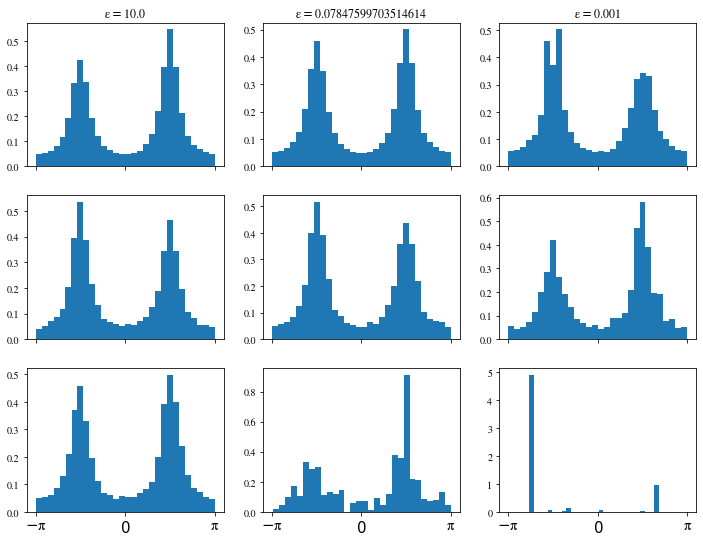

In [49]:
# Plot settings
compute_arctan = lambda point: math.atan2(*point[::-1])
rc('font',**{'family':'STIXGeneral'})

# Plot
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(12, 9), sharex=True)

SNAPSHOTS = [0, len(ϵs)//2 , -1]

# Markov Snippets - Full Trajectory (Version 1)
for i in range(3):
    _ = ax[0, i].hist(np.apply_along_axis(compute_arctan, 1, MSTHUG.ZNK[SNAPSHOTS[i], :, :2]), bins=30, density=True, weights=MSTHUG.Wbar[SNAPSHOTS[i]])
    ax[0, i].set_xticks([-math.pi, 0, math.pi])
    ax[0, i].set_xticklabels([r'$-\mathregular{\pi}$', r'$0$', r'$\mathregular{\pi}$'], fontsize=15)
    ax[0, i].set_title(r'$\mathregular{\epsilon}=$' + '{}'.format(ϵs[SNAPSHOTS[i]]))
    
# Markov Snippets - End-Only (Version 2)
for i in range(3):
    _ = ax[1, i].hist(np.apply_along_axis(compute_arctan, 1, MSTHUG_ONLYEND.ZNK[SNAPSHOTS[i], :, :2]), bins=30, density=True, weights=MSTHUG_ONLYEND.Wbar[SNAPSHOTS[i]])
    ax[1, i].set_xticks([-math.pi, 0, math.pi])
    ax[1, i].set_xticklabels([r'$-\mathregular{\pi}$', r'$0$', r'$\mathregular{\pi}$'], fontsize=15)
    
# SMC-THUG (Metropolised Version)
for i in range(3):
    _ = ax[2, i].hist(np.apply_along_axis(compute_arctan, 1, MSTHUG_METROP.PARTICLES[SNAPSHOTS[i], :, :2]), bins=30, density=True, weights=MSTHUG_METROP.WEIGHTS[SNAPSHOTS[i]])
    ax[2, i].set_xticks([-math.pi, 0, math.pi])
    ax[2, i].set_xticklabels([r'$-\mathregular{\pi}$', r'$0$', r'$\mathregular{\pi}$'], fontsize=15)

# Compare Efficiency

In [50]:
print("(Number of particles with non-zero weight for ϵ_P) / total sampling time: ")
print("MSv1: {:.1f}".format(np.sum(MSTHUG.Wbar[-1] > 0) / MSTHUG.total_time))
print("MSv2: {:.1f}".format(np.sum(MSTHUG_ONLYEND.Wbar[-1] > 0) / MSTHUG_ONLYEND.total_time))
print("SMC : {:.1f}".format(np.sum(MSTHUG_METROP.WEIGHTS[-1] > 0) / MSTHUG_METROP.total_time))

(Number of particles with non-zero weight for ϵ_P) / total sampling time: 
MSv1: 2290.5
MSv2: 164.6
SMC : 82.7


# Compare Expectations

In [32]:
# SMC-THUG: Mean Functional
def smc_mean(MS):
    W = MS.WEIGHTS[-1][..., None]
    Z = MS.PARTICLES[-1, :, :2]
    return np.sum(W*Z, axis=0)

# Markov-Snippets: Mean functional
def markov_snippets_mean(MS):
    W = MS.Wbar[-1].reshape(N, MS.B+1)[..., None] # (N, B+1, 1)
    Z = MS.ZNK[-1, :, :2].reshape(N, MS.B+1, 2)   # (N, B+1, 2)
    return np.sum(np.sum(W*Z, axis=1), axis=0)    # (2, )

In [51]:
print("Mean Functional")
print("MSv1: {:.0e} {:.0e}".format(*markov_snippets_mean(MSTHUG)))
print("MSv2: {:.0e} {:.0e}".format(*markov_snippets_mean(MSTHUG_ONLYEND)))
print("SMC : {:.0e} {:.0e}".format(*smc_mean(MSTHUG_METROP)))

Mean Functional
MSv1: -1e-04 -1e-01
MSv2: 8e-03 2e-01
SMC : -6e-01 -4e-01


# ESS plot

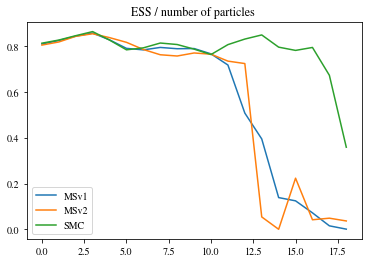

In [52]:
fig, ax = plt.subplots()
ax.plot(MSTHUG.ESS / (N*(B+1)), label='MSv1')
ax.plot(MSTHUG_ONLYEND.ESS / (2*N), label='MSv2')
ax.plot(MSTHUG_METROP.ESS[1:] / N, label='SMC')
ax.legend()
ax.set_title("ESS / number of particles ")
plt.show()

# Histograms of Resampled Indeces

In [53]:
def plot_histogram(n):
    fig, ax = plt.subplots(figsize=(20, 4))
    _, bins, _ = ax.hist(MSTHUG.K_RESAMPLED[n, :], density=True, bins=B, edgecolor='k', color='lightsalmon')
    ax.set_xticks(bins)
    ax.set_xticklabels(bins.astype(int))
    return plt.show()
    
interact(plot_histogram, n=(0, len(ϵs) - 2))

interactive(children=(IntSlider(value=9, description='n', max=18), Output()), _dom_classes=('widget-interact',…

<function __main__.plot_histogram(n)>